In [2]:
# --- SETUP CELL (FINAL CORRECTED VERSION) ---
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore warnings for a cleaner output
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


# --- 1. Load Your Datasets ---
master_data_path = '../output/India_District_Environmental_Indicators.csv'
shapefile_path = '../data/geospatial/in_district.shp'

df = pd.read_csv(master_data_path)
gdf_districts = gpd.read_file(shapefile_path)

# --- 2. Prepare for Merging ---
# THIS LINE IS NOW FIXED
# We are now renaming the correct column ('dtname') to 'DistrictName'
gdf_districts.rename(columns={'dtname': 'DistrictName'}, inplace=True)

# Merge your master data with the geospatial data
gdf_merged = pd.merge(gdf_districts, df, on='DistrictName', how='left')

print("✅ Setup complete. Data and shapefiles are loaded and merged.")
print(f"Total districts in master data: {len(df)}")
print(f"Total districts in merged GeoDataFrame: {len(gdf_merged)}")
display(gdf_merged.head())

✅ Setup complete. Data and shapefiles are loaded and merged.
Total districts in master data: 832
Total districts in merged GeoDataFrame: 781


,DistrictName,stname,stcode11,dtcode11,year_stat,Dist_LGD,State_LGD,JID,geometry,LGD_Code_x,...,AvgAQI_2020,very_dense_forest,mod_dense_forest,open_forest,total_forest_cover,scrub,LGD_Code_y,DistrictVehicles_2020,VehiclesPerCapita,ForestPerCapita_sqkm
0,Kupwara,JAMMU & KASHMIR,01,001,2011_c,8.0,1.0,598,"POLYGON ((74.33744 34.78209, 74.34695 34.78019...",8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,0.0,NaN,NaN
1,Bandipore,JAMMU & KASHMIR,01,009,2011_c,623.0,1.0,599,"POLYGON ((74.73338 34.67121, 74.74956 34.66883...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Baramula,JAMMU & KASHMIR,01,008,2011_c,3.0,1.0,600,"POLYGON ((74.51946 34.42533, 74.5209 34.42237,...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ganderbal,JAMMU & KASHMIR,01,011,2011_c,626.0,1.0,601,"POLYGON ((74.94144 34.46384, 74.94554 34.46247...",626.0,...,NaN,NaN,NaN,NaN,NaN,NaN,626.0,0.0,NaN,NaN
4,Anantnag,JAMMU & KASHMIR,01,014,2011_c,1.0,1.0,602,"POLYGON ((75.26949 34.25584, 75.27242 34.25356...",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN


In [3]:
# --- FINAL DATA CLEANING CELL: IMPUTING MISSING VALUES ---

# First, let's see how many missing values we have in each column
print("Missing values BEFORE cleaning:")
print(df.isnull().sum())

# 1. Fill missing AQI values with the average AQI of the state
# This is a good estimation method for this type of data.
print("\nFilling missing AQI values with state averages...")
df['AvgAQI_2020'] = df['AvgAQI_2020'].fillna(df.groupby('StateName')['AvgAQI_2020'].transform('mean'))

# 2. Fill missing Forest and Vehicle data with 0
# This is a safe assumption for these columns.
print("Filling missing forest and vehicle data with 0...")
forest_cols = ['very_dense_forest', 'mod_dense_forest', 'open_forest', 'total_forest_cover', 'scrub']
for col in forest_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

if 'DistrictVehicles_2020' in df.columns:
    df['DistrictVehicles_2020'].fillna(0, inplace=True)

# 3. Recalculate Per-Capita columns with the newly filled data
print("Recalculating per-capita metrics...")
# Avoid division by zero for districts with no population data
df.loc[df['Population'] > 0, 'VehiclesPerCapita'] = df['DistrictVehicles_2020'] / df['Population']
df.loc[df['Population'] > 0, 'ForestPerCapita_sqkm'] = df['total_forest_cover'] / df['Population']
# Fill any remaining NaN in these columns (for districts with 0 population) with 0
df[['VehiclesPerCapita', 'ForestPerCapita_sqkm']] = df[['VehiclesPerCapita', 'ForestPerCapita_sqkm']].fillna(0)


# 4. Final Check: Verify that there are no more missing values
print("\nMissing values AFTER cleaning:")
print(df.isnull().sum())

print("\n✅ Data cleaning and imputation complete! Your dataset is ready for analysis.")
display(df.head())

Missing values BEFORE cleaning:
LGD_Code_x                 0
DistrictName               0
StateName                  0
Population               278
MORTH_City_Name          777
AvgAQI_2020              737
very_dense_forest        574
mod_dense_forest         574
open_forest              574
total_forest_cover       574
scrub                    574
LGD_Code_y                 0
DistrictVehicles_2020      0
VehiclesPerCapita        278
ForestPerCapita_sqkm     624
dtype: int64

Filling missing AQI values with state averages...
Filling missing forest and vehicle data with 0...
Recalculating per-capita metrics...

Missing values AFTER cleaning:
LGD_Code_x                 0
DistrictName               0
StateName                  0
Population               278
MORTH_City_Name          777
AvgAQI_2020              277
very_dense_forest          0
mod_dense_forest           0
open_forest                0
total_forest_cover         0
scrub                      0
LGD_Code_y                 0
Dis

,LGD_Code_x,DistrictName,StateName,Population,MORTH_City_Name,AvgAQI_2020,very_dense_forest,mod_dense_forest,open_forest,total_forest_cover,scrub,LGD_Code_y,DistrictVehicles_2020,VehiclesPerCapita,ForestPerCapita_sqkm
0,554,Alappuzha,Kerala,2127789.0,NaN,68.379557,0.00,20.01,120.91,140.92,0.00,554,0,0.000000,0.000066
1,121,Ambedkar Nagar,Uttar Pradesh,2397888.0,NaN,176.918777,0.00,0.00,0.00,0.00,0.00,121,0,0.000000,0.000000
2,27,Amritsar,Punjab,2490656.0,NaN,105.312684,0.00,0.00,0.00,0.00,0.00,27,0,0.000000,0.000000
3,672,Arvalli,Gujarat,NaN,NaN,94.022789,0.86,63.13,215.55,279.54,32.57,672,0,0.000000,0.000000
4,611,Arwal,Bihar,700843.0,NaN,136.492945,0.00,1.44,2.58,4.02,0.00,611,796,0.001136,0.000006


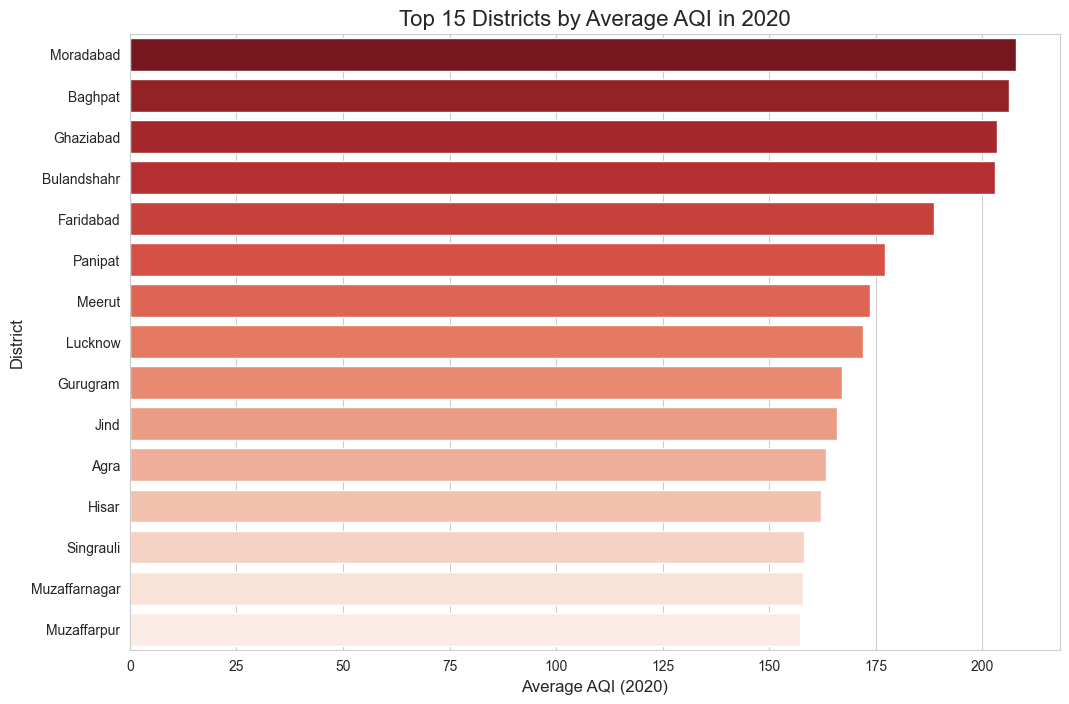

In [4]:
# --- Create a Bar Chart for Top 15 Districts by AQI ---

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

top_aqi_districts = gdf_merged.sort_values(by='AvgAQI_2020', ascending=False).head(15)

sns.barplot(
    x='AvgAQI_2020',
    y='DistrictName',
    data=top_aqi_districts,
    palette='Reds_r'
)

plt.title('Top 15 Districts by Average AQI in 2020', fontsize=16)
plt.xlabel('Average AQI (2020)', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.show()

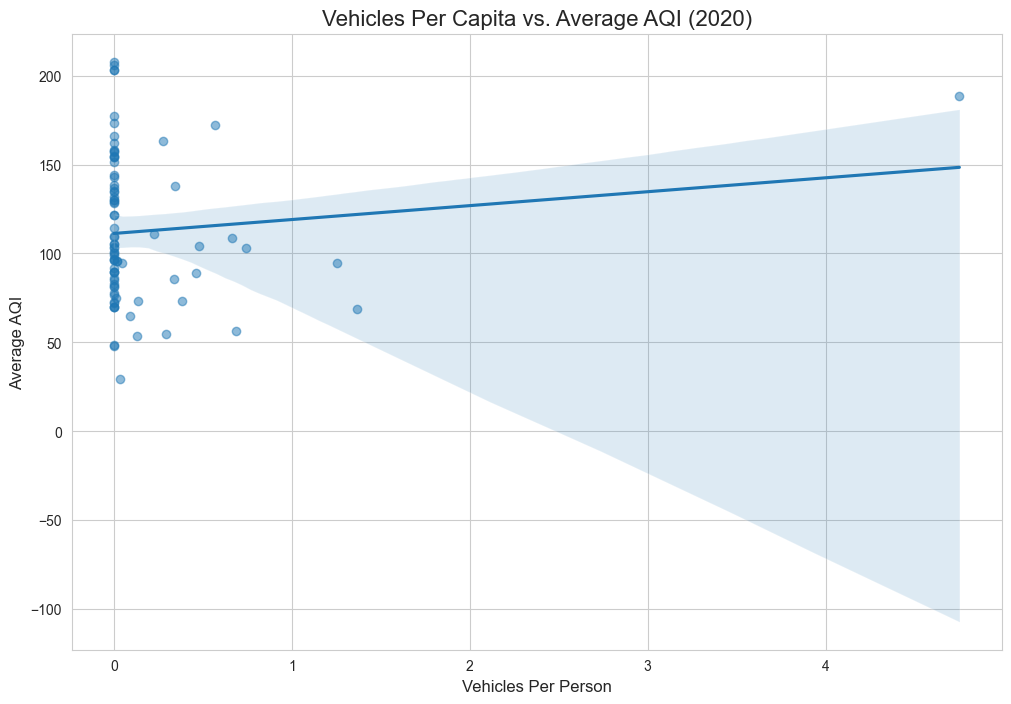

In [5]:
# --- Create a Scatter Plot: Vehicles Per Capita vs. AQI ---

plt.figure(figsize=(12, 8))

sns.regplot(
    x='VehiclesPerCapita', 
    y='AvgAQI_2020', 
    data=gdf_merged,
    scatter_kws={'alpha':0.5} 
)

plt.title('Vehicles Per Capita vs. Average AQI (2020)', fontsize=16)
plt.xlabel('Vehicles Per Person', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.show()

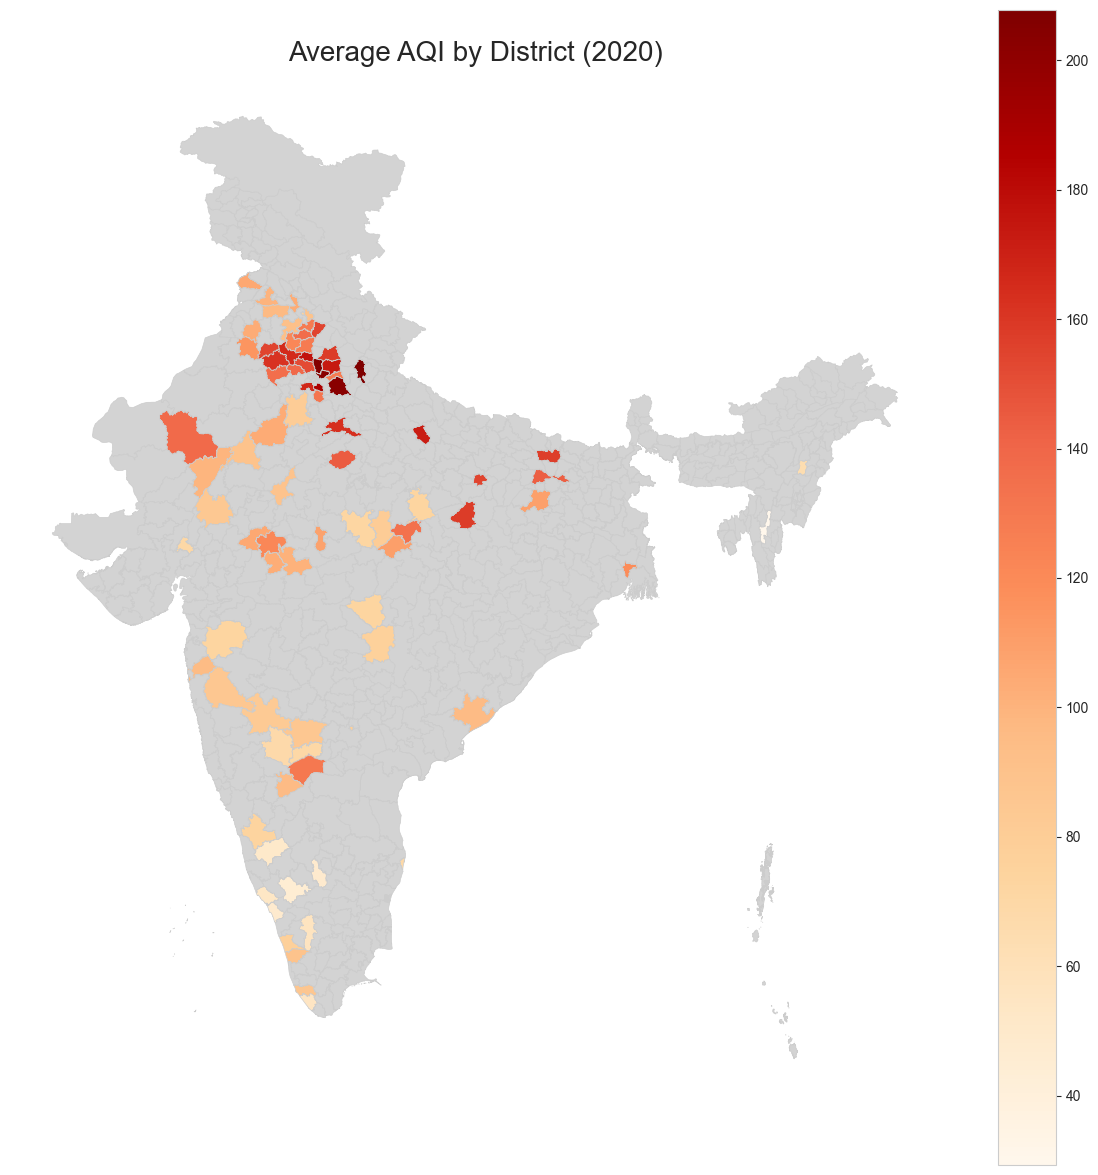

In [6]:
# --- Create a Choropleth Map of Average AQI 2020 ---

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

gdf_merged.plot(
    column='AvgAQI_2020', 
    cmap='OrRd', 
    linewidth=0.5, 
    ax=ax, 
    edgecolor='0.8', 
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing Data",
    }
)

ax.set_title('Average AQI by District (2020)', fontdict={'fontsize': '20', 'fontweight': '3'})
ax.axis('off')
plt.show()

In [7]:
df

,LGD_Code_x,DistrictName,StateName,Population,MORTH_City_Name,AvgAQI_2020,very_dense_forest,mod_dense_forest,open_forest,total_forest_cover,scrub,LGD_Code_y,DistrictVehicles_2020,VehiclesPerCapita,ForestPerCapita_sqkm
0,554,Alappuzha,Kerala,2127789.0,NaN,68.379557,0.00,20.01,120.91,140.92,0.00,554,0,0.000000,0.000066
1,121,Ambedkar Nagar,Uttar Pradesh,2397888.0,NaN,176.918777,0.00,0.00,0.00,0.00,0.00,121,0,0.000000,0.000000
2,27,Amritsar,Punjab,2490656.0,NaN,105.312684,0.00,0.00,0.00,0.00,0.00,27,0,0.000000,0.000000
3,672,Arvalli,Gujarat,NaN,NaN,94.022789,0.86,63.13,215.55,279.54,32.57,672,0,0.000000,0.000000
4,611,Arwal,Bihar,700843.0,NaN,136.492945,0.00,1.44,2.58,4.02,0.00,611,796,0.001136,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,697,Yadadri Bhuvanagiri,Telangana,NaN,NaN,77.991803,0.00,0.00,0.00,0.00,0.00,697,0,0.000000,0.000000
828,635,Yadgir,Karnataka,1174271.0,NaN,69.739130,0.00,17.26,129.21,146.47,131.95,635,0,0.000000,0.000125
829,635,Yadgir,Karnataka,1174271.0,NaN,69.739130,0.00,17.99,142.99,160.98,136.31,635,0,0.000000,0.000137
830,601,Yanam,Puducherry,55626.0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,601,0,0.000000,0.000000
